# Emotion classification using CNN

In [4]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np

## Load data

In [5]:
df = pd.read_csv('./data/fer2013.csv')
df.head(4)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training


In [6]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
NUM_CLASSES = len(CLASS_LABELS)
label_dict = {i:CLASS_LABELS[i] for i in np.arange(NUM_CLASSES)}

In [7]:
# Transform df column with pixels into a pytorch tensor
pixels = df['pixels']
pixels = pixels.apply(lambda x: x.split(" ")).tolist()
pixels = np.uint8(pixels)
pixels = torch.Tensor(pixels)
pixels = torch.reshape(pixels, (pixels.shape[0], 1, 48, 48))

In [8]:
train_idx = df.index[df['Usage'] == 'Training'].tolist()
val_idx   = df.index[df['Usage'] == 'PublicTest'].tolist()
test_idx  = df.index[df['Usage'] == 'PrivateTest'].tolist()

X_train = pixels[train_idx]
y_train = torch.Tensor(df.iloc[train_idx]['emotion'].tolist())
X_val = pixels[val_idx]
y_val = torch.Tensor(df.iloc[val_idx]['emotion'].tolist())
X_test = pixels[test_idx]
y_test = torch.Tensor(df.iloc[test_idx]['emotion'].tolist())

In [9]:
print(f'Train set shape: {list(X_train.shape)}, labels shape: {list(y_train.shape)}')
print(f'Validation set shape: {list(X_val.shape)}, labels shape: {list(y_val.shape)}')
print(f'Test set shape: {list(X_test.shape)}, labels shape: {list(y_test.shape)}')

Train set shape: [28709, 1, 48, 48], labels shape: [28709]
Validation set shape: [3589, 1, 48, 48], labels shape: [3589]
Test set shape: [3589, 1, 48, 48], labels shape: [3589]


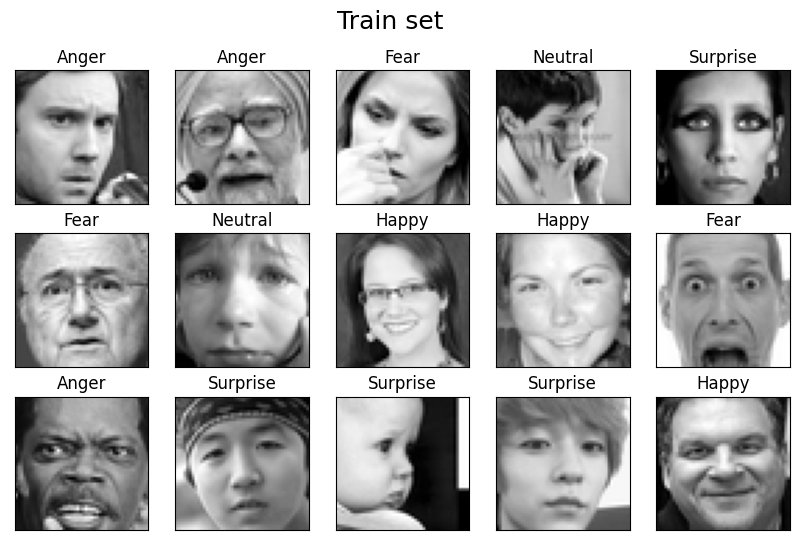

In [10]:
f, axarr = plt.subplots(3,5, figsize=(10,6))

for i in range(3):
    for j in range(5):
        axarr[i,j].imshow(X_train[5*i+j].squeeze(), cmap='gray')
        axarr[i,j].set_title(label_dict[int(y_train[5*i+j])])
        axarr[i,j].set_xticks([])
        axarr[i,j].set_yticks([])
plt.suptitle('Train set', fontsize=18)
plt.show()

## Create dataloaders

In [11]:
class EmotionDataset(Dataset):
    '''
    Inputs:
    - images: a [Batch size, Channels, Height, Width] tensor
    - labels: a 1-dimensional tensor corresponding to image labels
    - train: True if you want to apply transformations, False otherwise
    '''
    
    def __init__(self, images, labels, train:bool):
        self.images = images/255
        self.labels = labels
        self.train  = train
        

    def __getitem__(self, index):
        
        # Load the image (as tensor)
        img  = self.images[index]
        label = self.labels[index]
        
        # Apply transformations
        if self.train == True:
            img = self.transform(img)

        # Turn on gradient for image
        img = img.detach().clone().requires_grad_(True)
        
        return img, label

    
    def __len__(self):
        return len(self.images)
    
    
    def transform(self, img):
      
        # Horizontal flip
        if np.random.rand() < 0.3:
            t_horizonal_flip = T.RandomHorizontalFlip(p=1)
            img = t_horizonal_flip(img)

        # Add rotations
        if np.random.rand() < 0.3:
            t_rotation = T.RandomRotation(degrees=(-20, 20))
            img = t_rotation(img)

        return img

In [12]:
train_dataset = EmotionDataset(X_train, y_train, train=True)
val_dataset   = EmotionDataset(X_val, y_val, train=False)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader   = DataLoader(val_dataset  , batch_size=256, shuffle=False)

## Define CNN model

In [13]:
class CNN(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.model = nn.Sequential(
            # input image wiht size 48x48 
            # convolution will not change size due to padding, only pooling reduces the size in twice
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2), # image size 24x24
            nn.Dropout(p=0.25),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2), # image size 12x12
            nn.Dropout(p=0.25),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2), # image size 6x6 
            nn.Dropout(p=0.25),

            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2), # image size 3x3
            nn.Dropout(p=0.25),
            
            nn.Flatten(),
            nn.Linear(3 * 3 * 512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.25),

            nn.Linear(128, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.25),

            nn.Linear(512, 7),
        )

        # initialize weights for better convergence
        def initialize_weights(m):
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight.data, 1)
                nn.init.constant_(m.bias.data, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight.data)
                nn.init.constant_(m.bias.data, 0)

        self.model.apply(initialize_weights)
    
    def forward(self, x):
        return self.model(x)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)

In [15]:
optimizer = torch.optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)

## Training

In [111]:
epochs = 50
history = []

for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        images, labels = batch
        images = images
        predictions = model.forward(images.to(device))
        loss = criterion(predictions, labels.type(torch.LongTensor).to(device))
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()

    model.eval()
    val_losses = []
    val_accuracies = []
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            images, labels = batch
            images = images
            predictions = model.forward(images.to(device))
            loss = criterion(predictions, labels.type(torch.LongTensor).to(device))
            val_losses.append(loss.item())
            accuracy = torch.mean((torch.argmax(predictions, axis=1).cpu() == labels).float()).item()
            val_accuracies.append(accuracy)
    scheduler.step()
    result = {'train_loss': torch.mean(torch.tensor(train_losses)), 'val_loss': torch.mean(torch.tensor(val_losses)), 'val_acc': torch.mean(torch.tensor(val_accuracies))}
    history.append(result)
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, result['train_loss'], result['val_loss'], result['val_acc']))

100%|██████████| 15/15 [00:00<00:00, 104.01it/s]


Epoch [1], train_loss: 1.2091, val_loss: 1.1546, val_acc: 0.5441


100%|██████████| 15/15 [00:00<00:00, 105.63it/s]


Epoch [2], train_loss: 1.1953, val_loss: 1.1523, val_acc: 0.5472


100%|██████████| 15/15 [00:00<00:00, 105.60it/s]


Epoch [3], train_loss: 1.1842, val_loss: 1.1559, val_acc: 0.5508


100%|██████████| 15/15 [00:00<00:00, 101.93it/s]


Epoch [4], train_loss: 1.1858, val_loss: 1.1219, val_acc: 0.5634


100%|██████████| 15/15 [00:00<00:00, 104.10it/s]


Epoch [5], train_loss: 1.1766, val_loss: 1.1366, val_acc: 0.5490


100%|██████████| 15/15 [00:00<00:00, 102.66it/s]


Epoch [6], train_loss: 1.1712, val_loss: 1.1248, val_acc: 0.5495


100%|██████████| 15/15 [00:00<00:00, 103.45it/s]


Epoch [7], train_loss: 1.1552, val_loss: 1.1284, val_acc: 0.5545


100%|██████████| 15/15 [00:00<00:00, 107.14it/s]


Epoch [8], train_loss: 1.1558, val_loss: 1.1229, val_acc: 0.5573


100%|██████████| 15/15 [00:00<00:00, 105.63it/s]


Epoch [9], train_loss: 1.1492, val_loss: 1.1063, val_acc: 0.5586


100%|██████████| 15/15 [00:00<00:00, 102.76it/s]


Epoch [10], train_loss: 1.1388, val_loss: 1.1041, val_acc: 0.5741


100%|██████████| 15/15 [00:00<00:00, 101.88it/s]


Epoch [11], train_loss: 1.1350, val_loss: 1.1057, val_acc: 0.5743


100%|██████████| 15/15 [00:00<00:00, 103.34it/s]


Epoch [12], train_loss: 1.1309, val_loss: 1.1010, val_acc: 0.5743


100%|██████████| 15/15 [00:00<00:00, 102.38it/s]


Epoch [13], train_loss: 1.1244, val_loss: 1.1095, val_acc: 0.5618


100%|██████████| 15/15 [00:00<00:00, 102.63it/s]


Epoch [14], train_loss: 1.1146, val_loss: 1.0941, val_acc: 0.5759


100%|██████████| 15/15 [00:00<00:00, 104.30it/s]


Epoch [15], train_loss: 1.1180, val_loss: 1.0902, val_acc: 0.5772


100%|██████████| 15/15 [00:00<00:00, 103.92it/s]


Epoch [16], train_loss: 1.1138, val_loss: 1.0897, val_acc: 0.5780


100%|██████████| 15/15 [00:00<00:00, 103.03it/s]


Epoch [17], train_loss: 1.1069, val_loss: 1.0880, val_acc: 0.5850


100%|██████████| 15/15 [00:00<00:00, 100.64it/s]


Epoch [18], train_loss: 1.1102, val_loss: 1.0858, val_acc: 0.5832


100%|██████████| 15/15 [00:00<00:00, 104.04it/s]


Epoch [19], train_loss: 1.1038, val_loss: 1.0892, val_acc: 0.5801


100%|██████████| 15/15 [00:00<00:00, 101.81it/s]


Epoch [20], train_loss: 1.0982, val_loss: 1.0761, val_acc: 0.5897


100%|██████████| 15/15 [00:00<00:00, 103.03it/s]


Epoch [21], train_loss: 1.0891, val_loss: 1.0809, val_acc: 0.5827


100%|██████████| 15/15 [00:00<00:00, 100.59it/s]


Epoch [22], train_loss: 1.0960, val_loss: 1.0746, val_acc: 0.5858


100%|██████████| 15/15 [00:00<00:00, 98.58it/s]


Epoch [23], train_loss: 1.0862, val_loss: 1.0741, val_acc: 0.5803


100%|██████████| 15/15 [00:00<00:00, 53.95it/s]


Epoch [24], train_loss: 1.0794, val_loss: 1.0766, val_acc: 0.5847


100%|██████████| 15/15 [00:00<00:00, 55.69it/s]


Epoch [25], train_loss: 1.0851, val_loss: 1.0722, val_acc: 0.5879


100%|██████████| 15/15 [00:00<00:00, 59.18it/s]


Epoch [26], train_loss: 1.0791, val_loss: 1.0721, val_acc: 0.5907


100%|██████████| 15/15 [00:00<00:00, 57.32it/s]


Epoch [27], train_loss: 1.0771, val_loss: 1.0711, val_acc: 0.5871


100%|██████████| 15/15 [00:00<00:00, 58.57it/s]


Epoch [28], train_loss: 1.0746, val_loss: 1.0693, val_acc: 0.5866


100%|██████████| 15/15 [00:00<00:00, 75.80it/s]


Epoch [29], train_loss: 1.0686, val_loss: 1.0617, val_acc: 0.5879


100%|██████████| 15/15 [00:00<00:00, 59.88it/s]


Epoch [30], train_loss: 1.0740, val_loss: 1.0648, val_acc: 0.5863


100%|██████████| 15/15 [00:00<00:00, 56.42it/s]


Epoch [31], train_loss: 1.0614, val_loss: 1.0677, val_acc: 0.5902


100%|██████████| 15/15 [00:00<00:00, 58.85it/s]


Epoch [32], train_loss: 1.0618, val_loss: 1.0664, val_acc: 0.5889


100%|██████████| 15/15 [00:00<00:00, 59.90it/s]


Epoch [33], train_loss: 1.0572, val_loss: 1.0688, val_acc: 0.5889


100%|██████████| 15/15 [00:00<00:00, 56.36it/s]


Epoch [34], train_loss: 1.0588, val_loss: 1.0625, val_acc: 0.5886


100%|██████████| 15/15 [00:00<00:00, 51.20it/s]


Epoch [35], train_loss: 1.0536, val_loss: 1.0608, val_acc: 0.5863


100%|██████████| 15/15 [00:00<00:00, 60.73it/s]


Epoch [36], train_loss: 1.0547, val_loss: 1.0575, val_acc: 0.5902


100%|██████████| 15/15 [00:00<00:00, 57.28it/s]


Epoch [37], train_loss: 1.0481, val_loss: 1.0621, val_acc: 0.5899


100%|██████████| 15/15 [00:00<00:00, 55.29it/s]


Epoch [38], train_loss: 1.0499, val_loss: 1.0586, val_acc: 0.5889


100%|██████████| 15/15 [00:00<00:00, 67.44it/s]


Epoch [39], train_loss: 1.0604, val_loss: 1.0581, val_acc: 0.5915


100%|██████████| 15/15 [00:00<00:00, 53.48it/s]


Epoch [40], train_loss: 1.0500, val_loss: 1.0607, val_acc: 0.5899


100%|██████████| 15/15 [00:00<00:00, 59.58it/s]


Epoch [41], train_loss: 1.0509, val_loss: 1.0597, val_acc: 0.5913


100%|██████████| 15/15 [00:00<00:00, 54.15it/s]


Epoch [42], train_loss: 1.0507, val_loss: 1.0631, val_acc: 0.5758


100%|██████████| 15/15 [00:00<00:00, 54.94it/s]


Epoch [43], train_loss: 1.0510, val_loss: 1.0623, val_acc: 0.5905


100%|██████████| 15/15 [00:00<00:00, 55.90it/s]


Epoch [44], train_loss: 1.0464, val_loss: 1.0609, val_acc: 0.5897


100%|██████████| 15/15 [00:00<00:00, 57.62it/s]


Epoch [45], train_loss: 1.0440, val_loss: 1.0605, val_acc: 0.5920


100%|██████████| 15/15 [00:00<00:00, 58.79it/s]


Epoch [46], train_loss: 1.0436, val_loss: 1.0602, val_acc: 0.5923


100%|██████████| 15/15 [00:00<00:00, 58.56it/s]


Epoch [47], train_loss: 1.0459, val_loss: 1.0611, val_acc: 0.5899


100%|██████████| 15/15 [00:00<00:00, 57.47it/s]


Epoch [48], train_loss: 1.0386, val_loss: 1.0624, val_acc: 0.5920


100%|██████████| 15/15 [00:00<00:00, 65.22it/s]


Epoch [49], train_loss: 1.0441, val_loss: 1.0639, val_acc: 0.5902


100%|██████████| 15/15 [00:00<00:00, 59.92it/s]

Epoch [50], train_loss: 1.0433, val_loss: 1.0607, val_acc: 0.5918


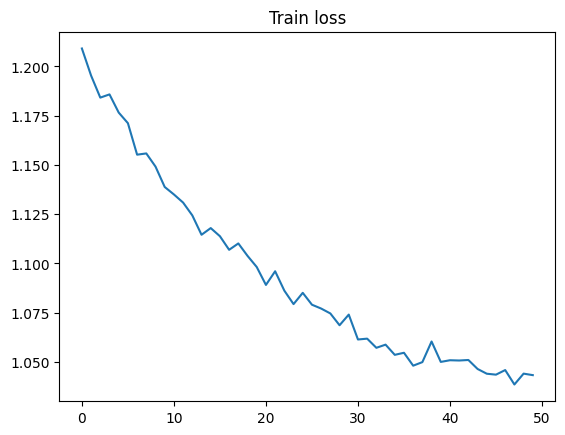

In [118]:
plt.plot([i['train_loss'].item() for i in history])
plt.title("Train loss")
plt.show()

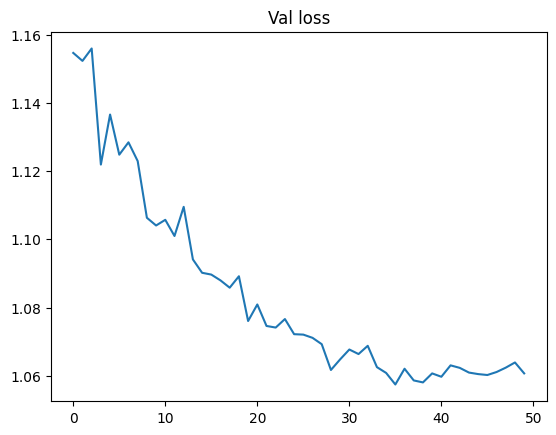

In [119]:
plt.plot([i['train_loss'].item() for i in history])
plt.title("Train loss")
plt.show()

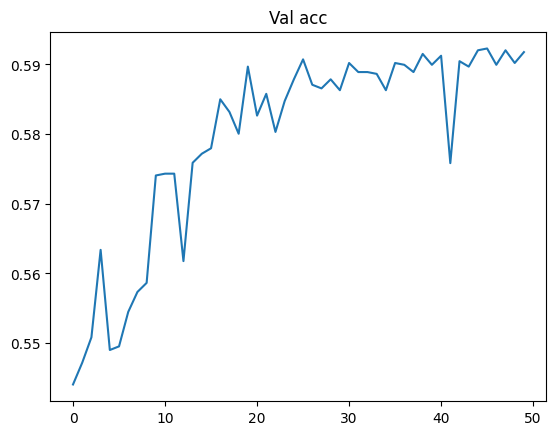

In [120]:
plt.plot([i['val_acc'].item() for i in history])
plt.title("Val acc")
plt.show()